In [1]:
# Following https://github.com/tsssss/geopack/blob/master/notebooks/Field%20Line%20Trace%20Demo.ipynb
# parmod parameters (incl. G1 and G2) taken from https://rbsp-ect.newmexicoconsortium.org/data_pub/QinDenton/
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.patches import Wedge, Circle, RegularPolygon
import numpy as np
from geopack import geopack

# Pulling THEMIS data from CDAWeb via the cdasws python library
from cdasws import CdasWs
cdas = CdasWs()

import os
import pandas as pd
from datetime import datetime, timezone
from tracing_tools import read_qindenton_json

#from platform import python_version
#print(python_version())

Load IGRF coefficients ...


In [2]:
# Set up X-Z plot
def dual_half_circle(center=(0,0), radius=1, angle=90, ax=None, colors=('w','k','k'),
                     **kwargs):
    """
    Add two half circles to the axes *ax* (or the current axes) with the 
    specified facecolors *colors* rotated at *angle* (in degrees).
    """
    if ax is None:
        ax = plt.gca()
    theta1, theta2 = angle, angle + 180
    #w1 = Wedge(center, radius, theta1, theta2, fc=colors[0], **kwargs)
    #w2 = Wedge(center, radius, theta2, theta1, fc=colors[1], **kwargs)
    
    w1 = Wedge(center, radius, theta1, theta2, fc=colors[1], **kwargs)
    w2 = Wedge(center, radius, theta2, theta1, fc=colors[0], **kwargs)
   
    cr = Circle(center, radius, fc=colors[2], fill=False, **kwargs)
    for wedge in [w1, w2, cr]:
        ax.add_artist(wedge)
    return [w1, w2, cr]

def setup_fig(xlim=(10,-30),ylim=(-20,20),xlabel='X GSM [Re]',ylabel='Z GSM [Re]'):

    fig = plt.figure(figsize=(15,10))
    ax  = fig.add_subplot(111)
    ax.axvline(0,ls=':',color='k')
    ax.axhline(0,ls=':',color='k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_aspect('equal')
    w1,w2,cr = dual_half_circle(ax=ax)
    
    return ax
#ax = setup_fig(xlim=(-10,10),ylim=(-10,10))

In [ ]:
#setup_fig()

In [5]:
# Using CdasWs instead of pySPEDAS for THEMIS coordinates
tha_coords = cdas.get_data('THA_OR_SSC', ['XYZ_GSM'], 
                          '2010-04-04T11:45:00Z', '2010-04-04T11:45:00Z')[1]
print(tha_coords['XYZ_GSM'])
print(tha_coords['Epoch'])

[-9.6564064  -3.9452064   1.38141799]
[datetime.datetime(2010, 4, 4, 11, 45)]


In [7]:
tha_x,tha_y,tha_z = tha_coords['XYZ_GSM']
print(tha_x,tha_y,tha_z)

-9.65640640258789 -3.9452064037323 1.381417989730835


In [ ]:
print(os.getcwd())
cwd = os.getcwd()

g_params_dir = os.path.join(cwd, 'QinDenton_Parameters/rbsp-ect.newmexicoconsortium.org/data_pub/QinDenton/')
print(g_params_dir)

g_file = os.path.join(cwd, 'QinDenton_Parameters/rbsp-ect.newmexicoconsortium.org/data_pub/QinDenton/2010/QinDenton_20100404_1min.txt')

In [27]:
readtest = read_qindenton_json(os.path.join(cwd, 'QinDenton_Parameters/rbsp-ect.newmexicoconsortium.org/data_pub/QinDenton/2010/QinDenton_20100404_1min.txt'))
gs = readtest[705]
gs

{'DateTime': '2010-04-04T11:45:00',
 'Year': '2010',
 'Month': '4',
 'Day': '4',
 'Hour': '11',
 'Minute': '45',
 'Second': '00',
 'ByIMF': '-3.79',
 'BzIMF': '-1.53',
 'Vsw': '471.0',
 'Den_P': '2.99',
 'Pdyn': '1.33',
 'G': {'G1': '1.33', 'G2': '2.08', 'G3': '2.59'},
 'ByIMF_status': '2',
 'BzIMF_status': '2',
 'Vsw_status': '2',
 'Den_P_status': '2',
 'Pdyn_status': '2',
 'G_status': {'G1_status': '2', 'G2_status': '2', 'G3_status': '2'},
 'Kp': '1.40',
 'akp3': '2.30',
 'Dst': '-23',
 'Bz': {'Bz1': '-23',
  'Bz2': '-1.53',
  'Bz3': '-1.53',
  'Bz4': '-1.53',
  'Bz5': '-1.53',
  'Bz6': '-1.53'},
 'W': {'W1': '-23',
  'W2': '-1.53',
  'W3': '-1.53',
  'W4': '-1.53',
  'W5': '-1.53',
  'W6': '-1.53'},
 'W_status': {'W1_status': '-23',
  'W2_status': '-1.53',
  'W3_status': '-1.53',
  'W4_status': '-1.53',
  'W5_status': '-1.53',
  'W6_status': '-1.53'}}

In [10]:
# Verifying UT datetime stuff for use with recalc()
tha_dt = (tha_coords['Epoch'])[0]
print(tha_dt)
#print(pd.to_datetime(tha_dt))
tha_seconds = tha_dt.timestamp()
print(tha_seconds)

# NOTE:
# CdasWs ASSUMES UTC in the time-string input, but then returns a datetime object, 
# WHICH YOUR COMPUTER WILL THEN INTERPRET AS BEING IN LOCAL TIME, NOT UTC.
# Correction:
tha_seconds = tha_dt.replace(tzinfo=timezone.utc).timestamp()
print(tha_seconds)
print(datetime.fromtimestamp(tha_seconds, timezone.utc)) #checking if correct in UTC

2010-04-04 11:45:00
1270395900.0
1270381500.0
2010-04-04 11:45:00+00:00


In [11]:
x_gsm = tha_x
y_gsm = tha_y
z_gsm = tha_z
ut = tha_seconds #0.0 # this matters. Give as UT in seconds
ps = geopack.recalc(ut)

pm = [
    float(gs['Pdyn']),
    float(gs['Dst']),
    float(gs['ByIMF']),
    float(gs['BzIMF']),
    float(gs['G']['G1']),
    float(gs['G']['G2']),
    ps,
    x_gsm,
    y_gsm,
    z_gsm
]
# Test trace() method
x,y,z,xx,yy,zz = geopack.trace(x_gsm,y_gsm,z_gsm,dir=1,rlim=21,r0=.99999,
                              parmod=pm,exname='t01',inname='igrf',maxloop=10000)
print(xx,zz)

[-9.6564064  -9.75679654 -9.77383014 -9.76520036 -9.68365257 -9.54980742
 -9.38968523 -9.0332131  -8.6525102  -8.25805973 -7.85399368 -7.44254452
 -7.0251027  -6.60233895 -6.17423899 -5.74033519 -5.3001269  -4.85352131
 -4.40105122 -3.94390513 -3.02432048 -2.12163603 -1.75500672 -1.46724773
 -1.24254676 -1.06747449 -0.93107539 -0.82464528 -0.74137856 -0.67601779
 -0.62452866 -0.58382389 -0.57571807 -0.56803224 -0.56074351 -0.55383033
 -0.54727241] [ 1.38141799  1.15401282  1.03073313  0.90749773  0.67772234  0.47579267
  0.29548215 -0.02396501 -0.30891866 -0.57000262 -0.81160927 -1.03613291
 -1.24503163 -1.43859875 -1.61560314 -1.77339033 -1.90838649 -2.0166194
 -2.09401196 -2.13648501 -2.10082395 -1.88098909 -1.72769465 -1.57572342
 -1.43435413 -1.30806756 -1.19832599 -1.1048203  -1.02629353 -0.96105953
 -0.90731468 -0.86331472 -0.85439253 -0.84588377 -0.83777089 -0.83003691
 -0.82266541]


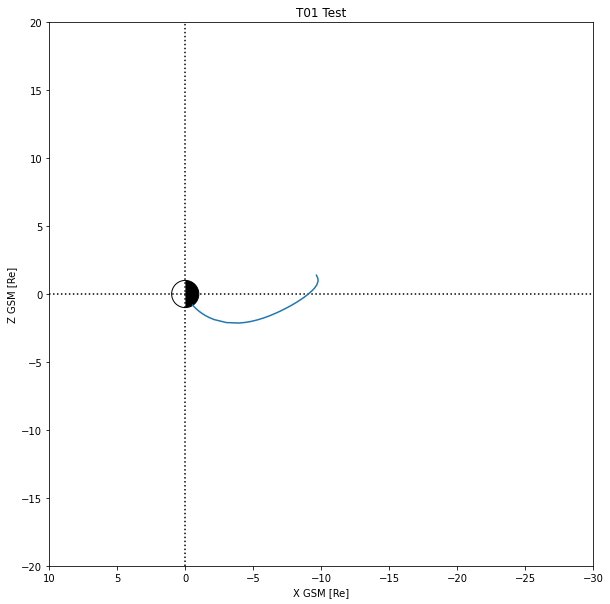

[-9.6564064  -9.75679654 -9.77383014 -9.76520036 -9.68365257 -9.54980742
 -9.38968523 -9.0332131  -8.6525102  -8.25805973 -7.85399368 -7.44254452
 -7.0251027  -6.60233895 -6.17423899 -5.74033519 -5.3001269  -4.85352131
 -4.40105122 -3.94390513 -3.02432048 -2.12163603 -1.75500672 -1.46724773
 -1.24254676 -1.06747449 -0.93107539 -0.82464528 -0.74137856 -0.67601779
 -0.62452866 -0.58382389 -0.57571807 -0.56803224 -0.56074351 -0.55383033
 -0.54727241] [ 1.38141799  1.15401282  1.03073313  0.90749773  0.67772234  0.47579267
  0.29548215 -0.02396501 -0.30891866 -0.57000262 -0.81160927 -1.03613291
 -1.24503163 -1.43859875 -1.61560314 -1.77339033 -1.90838649 -2.0166194
 -2.09401196 -2.13648501 -2.10082395 -1.88098909 -1.72769465 -1.57572342
 -1.43435413 -1.30806756 -1.19832599 -1.1048203  -1.02629353 -0.96105953
 -0.90731468 -0.86331472 -0.85439253 -0.84588377 -0.83777089 -0.83003691
 -0.82266541]
10.52231694268628


In [12]:
# Testing a T01 X-Z plot
ax=setup_fig()
ax.plot(xx,zz)
plt.title('T01 Test')
plt.show()
print(xx,zz)
print(np.sqrt(x_gsm**2+y_gsm**2+z_gsm**2))

# Main functions

### File finder

In [ ]:
# locate 1-minute cadence g parameters data from date/time
# Assumes input is a string of form 'YYYYMMDDHHMM'
def get_g_file(timestamp):
    dirstr = 'QinDenton_Parameters/rbsp-ect.newmexicoconsortium.org/data_pub/QinDenton/'
    dirstr = dirstr+timestamp[0:4]+'/QinDenton_'+timestamp[0:8]+'_1min.txt'
    g_file = os.path.join(os.getcwd(), dirstr)
    return g_file
# Test
print(get_g_file('201004041145'))

### g parameters extractor

In [15]:
# Extract g parameters from file for "parmod" array 
# (will still need to append recalc(ut) and sat gsm_xyz to resulting glist for use in trace())
# Need to find which entry in the list produced by read_qindenton_json
# corresponds to the correct timestamp
# Helper function to find the right dictionary for the given timestamp
def find_dict_in_list(lst, key, val):
    for i, dic in enumerate(lst):
        if dic[key] == val:
            return i
    return 'Something has gone terribly wrong'

def get_g_params(timestamp):
    g_file = get_g_file(timestamp)
    g_list = read_qindenton_json(g_file) #need to find the line for the given timestamp
    ts = str(timestamp)
    ts = ts[0:4]+'-'+ts[4:6]+'-'+ts[6:8]+'T'+ts[8:10]+':'+ts[10:12]+':00'
    g_data = g_list[find_dict_in_list(g_list, 'DateTime', ts)]
    g_data = [
        float(g_data['Pdyn']),
        float(g_data['Dst']),
        float(g_data['ByIMF']),
        float(g_data['BzIMF']),
        float(g_data['G']['G1']),
        float(g_data['G']['G2']),
    ]    
    return g_data
# Test
g_test = get_g_params('201004041145')
print(g_test)
# Should be [1.33, -23.0, -3.79, -1.53, 1.33, 2.08]

[1.33, -23.0, -3.79, -1.53, 1.33, 2.08]


### UNIX/POSIX epoch converter (from str(datetime))

In [16]:
# Converts timestamp to seconds since the unix epoch (in UTC)
# assumes dt is a datetime object
def get_epoch(dt):
    seconds = dt.replace(tzinfo=timezone.utc).timestamp()
    return seconds
print(get_epoch(pd.to_datetime('2010-04-04 11:45:00')))

1270381500.0


### Zero-z coordinate index finder

In [17]:
# Return index where field line goes closest to z=0 and its value
def find_nearest_z(z_arr, value):
    array = np.asarray(z_arr)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [18]:
# String manipulation test
print(tha_dt)
print(str(tha_dt)[0:4]+str(tha_dt)[5:7]+str(tha_dt)[8:10]+str(tha_dt)[11:13]+str(tha_dt)[14:16])

2010-04-04 11:45:00
201004041145


### Already-built functions (used for testing below)

In [19]:
# compress datetime64[s] to a string for saving files ([s] indicates precision to sec)
def datetimestr(map_time):
    full = str(map_time)
    dtstr = full[0:4]+full[5:7]+full[8:10]+full[11:13]+full[14:16]
    return dtstr #'YYYYMMDDHHMM'

# get THEMIS satellite coordinates from CDAWeb
# assumes datetime64[s] for timestamp input
def get_th_xyz(th_sat, timestamp):
    if th_sat in ('a', 'd', 'e'):
        satstr = 'TH' + th_sat.upper() + '_OR_SSC' #cdaWs expects 'THX_OR_SSC'
        #replace ' ' with 'T' in 'yyyy-mm-dd hh:mm:ss' of str(timestamp) and append 'Z' to end
        timestamp = str(timestamp).replace(' ', 'T')+'Z'
        xyz = cdas.get_data(satstr, ['XYZ_GSM'], timestamp, timestamp)[1]['XYZ_GSM']
        ### PROBLEM: THA_OR_SSC on CDAWeb for 2014-08-XX gives duplicate timestamps & coords. 
        ### Fix: check that get_data() returns a 1D array.
        if(len(np.shape(xyz))) != 1: xyz = xyz[0]
        return xyz
    print('Must give char (a, d, e) for th_sat')
    return

### Projected x-y footpoint (@ z=0) getter

In [20]:
# Takes: dt, th_loc[x,y,z] (assumes get_th_xyz() has already been called)
# Returns: x,y coordinates of the traced equatorial "footpoint"
def get_footpoint(x_gsm, y_gsm, z_gsm, dt):
    # get smushed string form of test_time (used in get_g_file(), get_g_params())
    timestr = datetimestr(dt)
    # Calculate dipole tilt angle
    ut = get_epoch(dt)
    ps = geopack.recalc(ut)
    # Assemble parmod array
    pm = get_g_params(timestr)+[ps,x_gsm,y_gsm,z_gsm]
    # Calculate field line (both directions)
    x,y,z,xx,yy,zz = geopack.trace(x_gsm,y_gsm,z_gsm,dir=1,rlim=21,r0=.99999,
                                   parmod=pm,exname='t01',inname='igrf',maxloop=1000)
    x2,y2,z2,xx2,yy2,zz2 = geopack.trace(x_gsm,y_gsm,z_gsm,dir=-1,rlim=21,r0=.99999,
                                   parmod=pm,exname='t01',inname='igrf',maxloop=1000)
    xx = np.concatenate((np.flip(xx2), xx))
    yy = np.concatenate((np.flip(yy2), yy))
    zz = np.concatenate((np.flip(zz2), zz))
    # Check that field lines start and terminate at Earth
    if (abs(xx[0]) > 1 or abs(xx[-1]) > 1):
        print('Field line failed to terminate: TH'+th_sat.upper()+': ' + str(test_time))
    mindex, z_min = find_nearest_z(zz, 0)
    xf = xx[mindex]
    yf = yy[mindex]    
    return xf,yf
testx,testy,testz = get_th_xyz('a', pd.to_datetime('2010-08-05 11:45:00'))
print(get_footpoint(testx, testy, testz, pd.to_datetime('2010-08-05 11:45:00')))
# should be ~(-0.574, -1.721)

(0.5745032429695129, -1.720522165298462)


### Full workflow testing cell

2010-04-04 11:45:00
1270381500.0
42 -0.023965007013740436
[-9.6564064  -3.9452064   1.38141799]


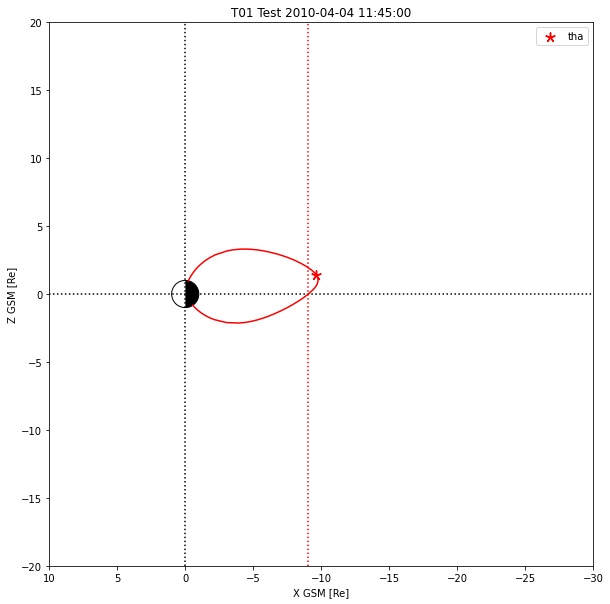

In [21]:
def sketch_field(th_sat, test_time, ax=None, **plot_kwargs):
    # get smushed string form of test_time (used in get_g_file(), get_g_params())
    timestr = datetimestr(test_time)
    # get THEMIS coordinates
    x_gsm,y_gsm,z_gsm = get_th_xyz(th_sat, test_time)
    # Calculate dipole tilt angle
    ut = get_epoch(test_time)
    ps = geopack.recalc(ut)
    # Assemble parmod array
    pm = get_g_params(timestr)+[ps,x_gsm,y_gsm,z_gsm]
    
    # Calculate field line (both directions)
    x,y,z,xx,yy,zz = geopack.trace(x_gsm,y_gsm,z_gsm,dir=1,rlim=31,r0=.99999,
                                   parmod=pm,exname='t01',inname='igrf',maxloop=1000)
    x2,y2,z2,xx2,yy2,zz2 = geopack.trace(x_gsm,y_gsm,z_gsm,dir=-1,rlim=31,r0=.99999,
                                   parmod=pm,exname='t01',inname='igrf',maxloop=1000)
    xx = np.concatenate((np.flip(xx2), xx))
    yy = np.concatenate((np.flip(yy2), yy))
    zz = np.concatenate((np.flip(zz2), zz))
    # Check that field lines start and terminate at Earth
    if (abs(xx[0]) > 1 or abs(xx[-1]) > 1):
        print('Field line failed to terminate: TH'+th_sat.upper()+': ' + str(test_time))
    
    # Plot figure
    if ax is None: ax = plt.gca()
    ax.plot(xx,zz,**plot_kwargs)
    ax.scatter(x_gsm, z_gsm, s=80, marker=(5,2), label='th'+th_sat, zorder=2.5, **plot_kwargs)
    plt.title('T01 Test ' + str(test_time))
    mindex, z_min = find_nearest_z(zz, 0)
    print(mindex, z_min)
    ax.axvline(xx[mindex],ls=':',**plot_kwargs)#color='r')
    #plt.show() #redundant; called automatically by matplotlib inline
    return(ax)

# Testing
map_time = pd.to_datetime('2010-04-04 11:45:00')#'2014-08-05 11:45:00')
print(map_time)
print(get_epoch(map_time))
test_ax=setup_fig()
sketch_field('a', map_time, c='r')
plt.legend()
print(get_th_xyz('a', map_time))

61 -0.009789708028400707
33 -0.12404501936567047
46 -0.021083056213939744
37 -0.0027924035231002287
25 -0.00022113256686484561
31 -0.07239966760057948
47 -0.004189772822157378
74 -0.11589776440193589
242 -0.004046617840364003
37 0.01577311889105454
12 0.02127993106842041
24 0.0932178364552334
71 -0.033162676247835365
60 -0.06956563804290597
74 -0.031089477466513346
35 0.0006899447015688842
48 0.01888636462589996
50 -0.07779465531336813


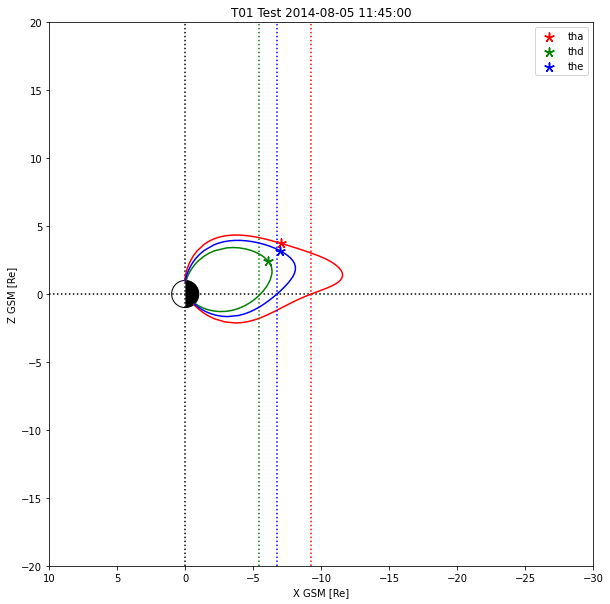

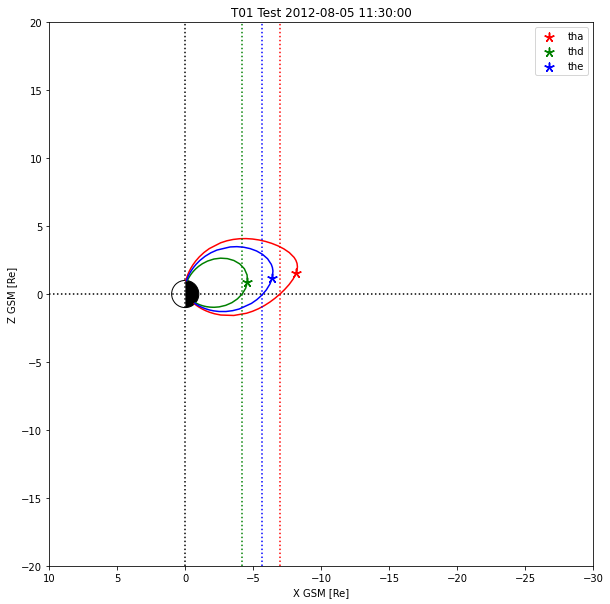

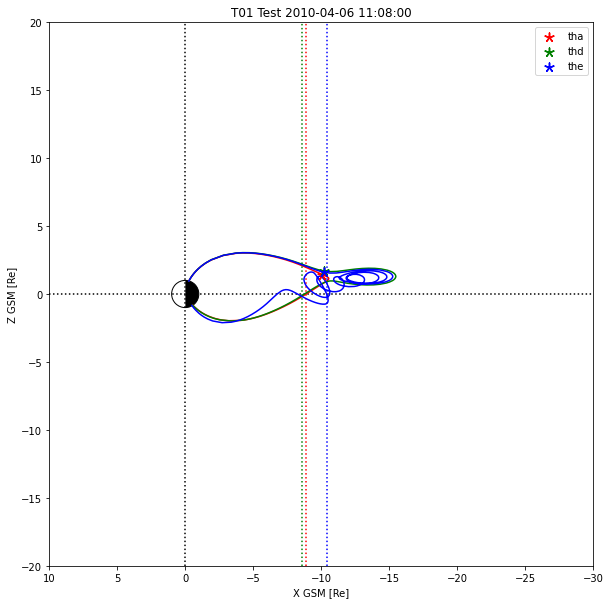

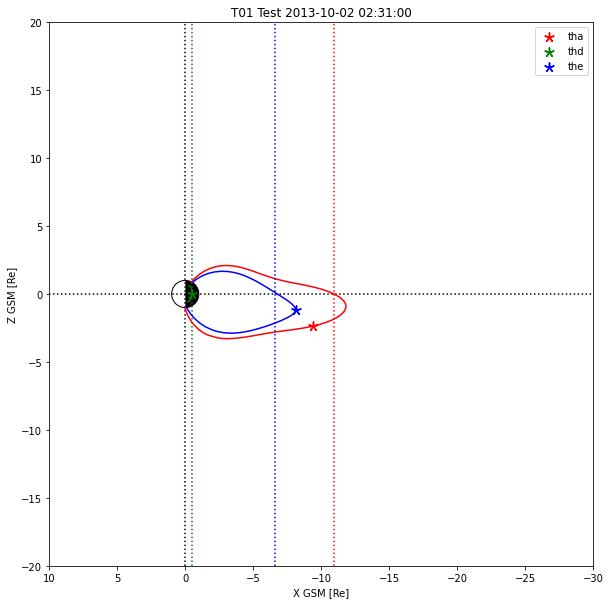

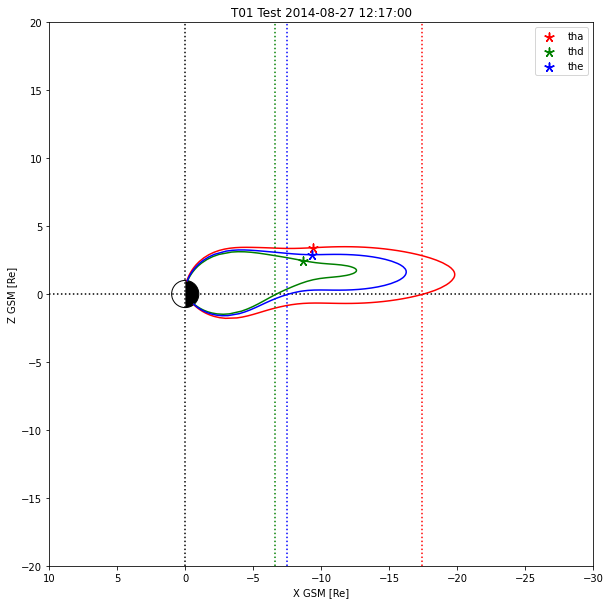

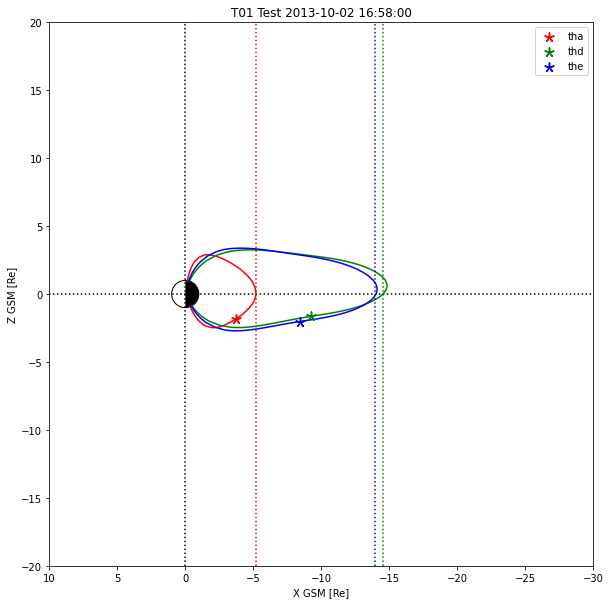

In [22]:
# Plot all 3 satellite coordinates
def trace_all_themis(test_time):
    ax=setup_fig()
    sketch_field('a', test_time, c='r')
    sketch_field('d', test_time, c='g')
    sketch_field('e', test_time, c='b')
    plt.legend()
    #plt.show() #technically redundant, but removes the "<legend at 123450xFF>" msg
    #return ax

map_time = pd.to_datetime('2014-08-05 11:45:00')
trace_all_themis(map_time)
trace_all_themis(pd.to_datetime('2012-08-05 11:30:00'))
trace_all_themis(pd.to_datetime('2010-04-06 11:08:00')) # weird one (wiggly)
trace_all_themis(pd.to_datetime('2013-10-02 02:31:00'))
trace_all_themis(pd.to_datetime('2014-08-27 12:17:00')) # THA didn't trace down to plane (r21)
trace_all_themis(pd.to_datetime('2013-10-02 16:58:00'))

#Edge cases to check
###Wiggly ones
#trace_all_themis(pd.to_datetime('2010-04-06 10:36:00'))
#trace_all_themis(pd.to_datetime('2010-04-06 10:40:00'))
#trace_all_themis(pd.to_datetime('2010-04-06 10:43:00'))
#trace_all_themis(pd.to_datetime('2010-04-06 10:47:00'))
###Long ones
#trace_all_themis(pd.to_datetime('2010-04-06 10:54:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:06:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:17:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:20:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:31:00'))
###Long ones cont.
#trace_all_themis(pd.to_datetime('2014-08-27 12:35:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:38:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:42:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:45:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:49:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:53:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 12:56:00'))
#trace_all_themis(pd.to_datetime('2014-08-27 13:00:00'))

### Notes ###
# maxloop = 1000 seems to be enough to get identical results to 10000.
# rlim = 31 catches cases of early termination, but MIGHT break far downtail (uncertain)
# (previously had rlim = 21)

40 0.05450768950925525
43 -0.009320431422681283
43 -0.036321836886687914
18 0.029259329294550995
Field line failed to terminate: THD: 2016-08-03 05:47:00
64 -0.02279694941527266
27 -0.22254127986157318
33 -0.058161058031197865
16 -0.0913897305727005
23 0.006295084410286089
42 -0.023965007013740436
41 -0.02434104111938129
43 -0.031706962047585496
27 -0.06854683094101705
24 0.01757444885127274
25 -0.1421335564476079


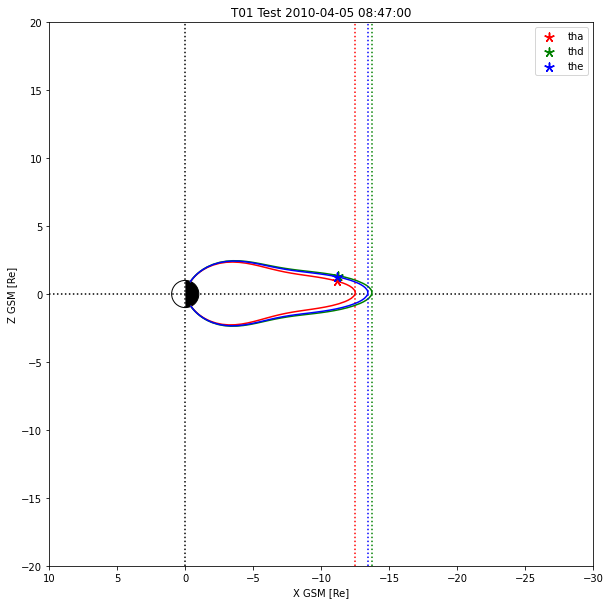

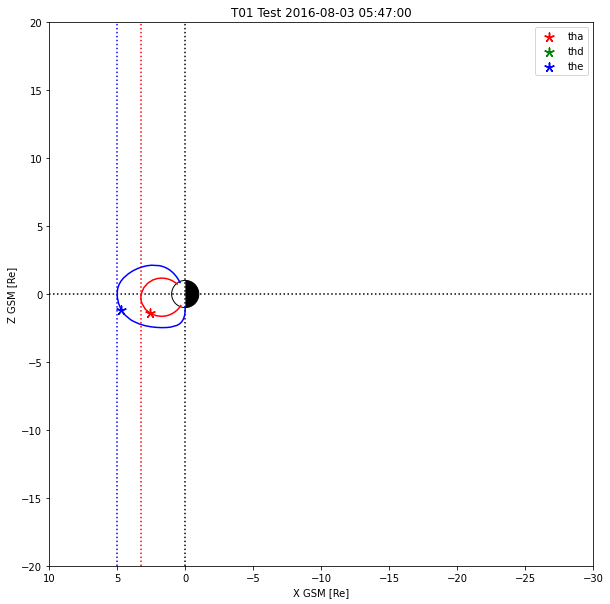

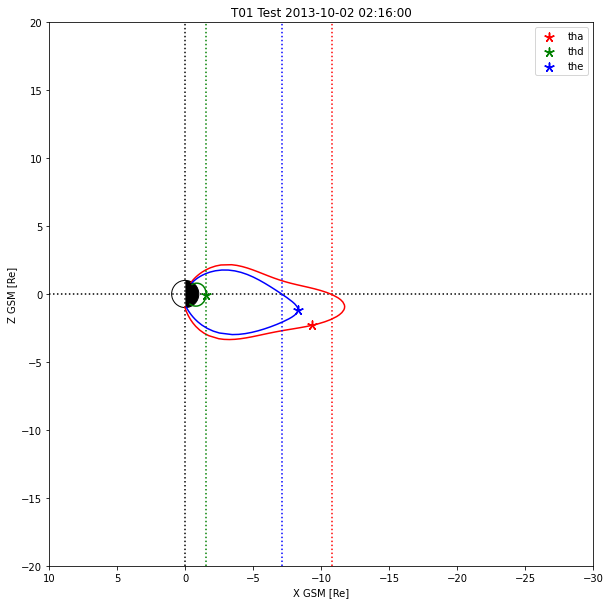

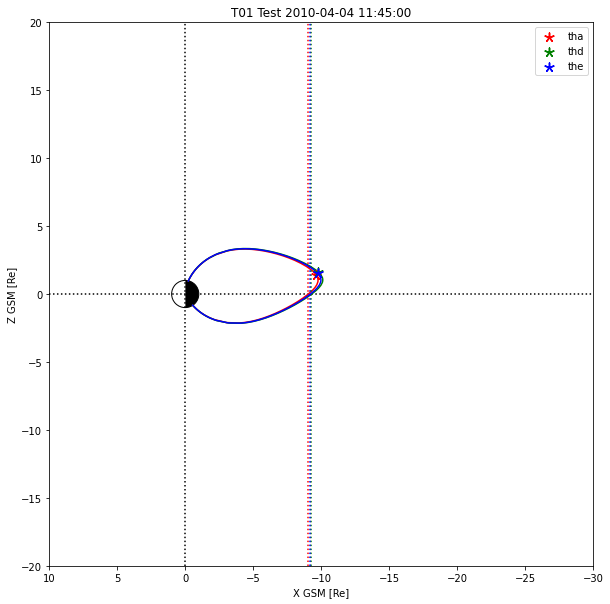

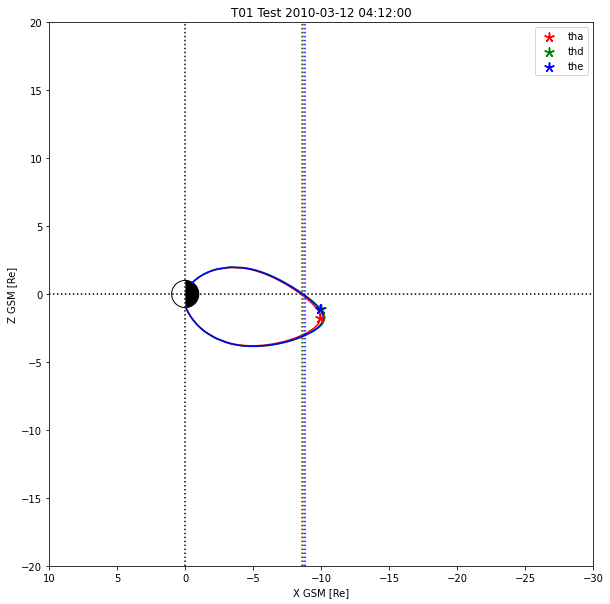

In [23]:
# Testing JGR figs timestamps
#trace_all_themis(pd.to_datetime('2016-04-04 12:00:00')) #EDGE CASE
trace_all_themis(pd.to_datetime('2010-04-05 08:47:00')) #fig 1
trace_all_themis(pd.to_datetime('2016-08-03 05:47:00')) #fig 2
trace_all_themis(pd.to_datetime('2013-10-02 02:16:00')) #fig 3
trace_all_themis(pd.to_datetime('2010-04-04 11:45:00')) #fig 4
trace_all_themis(pd.to_datetime('2010-03-12 04:12:00')) #fig 5

Variable           Type        Data/Info
----------------------------------------
Circle             type        <class 'matplotlib.patches.Circle'>
Wedge              type        <class 'matplotlib.patches.Wedge'>
dual_half_circle   function    <function dual_half_circle at 0x000001F3A9F935E8>
geopack            module      <module 'geopack.geopack'<...>es\\geopack\\geopack.py'>
km_to_re           function    <function km_to_re at 0x000001F3AA0F7678>
mpl                module      <module 'matplotlib' from<...>matplotlib\\__init__.py'>
np                 module      <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
plt                module      <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
pyspedas           module      <module 'pyspedas' from '<...>\\pyspedas\\__init__.py'>
pytplot            module      <module 'pytplot' from 'C<...>s\\pytplot\\__init__.py'>
setup_fig          function    <function setup_fig at 0x000001F3A9F933A8>
tha_t_range        list        n=2


In [ ]:
help(geopack.trace)

In [ ]:
help(geopack.recalc)

In [ ]:
help(geopack.t01.t01)

In [ ]:
help(geopack.t89)

In [ ]:
%whos

In [ ]:
help(geopack.t96.t96)